In [13]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, accuracy_score, f1_score)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
class StarRatingSentimentAnalyzer:
    def __init__(self):
        self.vectorizer = None
        self.model = None
        self.lemmatizer = WordNetLemmatizer()
        print("StarRatingSentimentAnalyzer initialized!")
    
    def preprocess_text(self, text):
        """Enhanced text preprocessing"""
        if pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = str(text).lower()
        
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        stopset = set(stopwords.words('english'))
        tokens = [self.lemmatizer.lemmatize(token) 
                 for token in tokens if token not in stopset and len(token) > 2]
        
        return ' '.join(tokens)
    
    def load_and_prepare_data(self, filepath):
        """Load and prepare the dataset with proper error handling"""
        try:
            # Load data
            df = pd.read_csv(filepath)
            print(f"Dataset loaded successfully. Shape: {df.shape}")
            print(f"Columns: {df.columns.tolist()}")
            
            # Check required columns
            if 'reviewText' not in df.columns:
                text_cols = [col for col in df.columns if 'review' in col.lower() or 'text' in col.lower() or 'comment' in col.lower()]
                if text_cols:
                    df['reviewText'] = df[text_cols[0]]
                    print(f"Using '{text_cols[0]}' as review text column")
                else:
                    print("No suitable text column found!")
                    return None
            
            if 'rating' not in df.columns:
                rating_cols = [col for col in df.columns if 'rating' in col.lower() or 'score' in col.lower() or 'label' in col.lower()]
                if rating_cols:
                    df['rating'] = df[rating_cols[0]]
                    print(f"Using '{rating_cols[0]}' as rating column")
                else:
                    print("No suitable rating column found!")
                    return None
            
            # Handle missing values
            initial_rows = len(df)
            df = df.dropna(subset=['reviewText', 'rating'])
            print(f"Removed {initial_rows - len(df)} rows with missing values")
            
            return df
            
        except FileNotFoundError:
            print(f"File not found: {filepath}")
            return None
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            return None
    
    def create_star_ratings(self, df):
        """Convert ratings to 0-5 star system and create training data"""
        print("Rating distribution before conversion:")
        print(df['rating'].value_counts().sort_index())
        
        unique_ratings = sorted(df['rating'].unique())
        print(f"Unique ratings: {unique_ratings}")
        
        # Convert to 0-5 star system
        if set(unique_ratings) <= {1, 2, 3, 4, 5}:
            # Already 1-5, convert to 0-4 then scale to 0-5
            df['star_rating'] = df['rating'] - 1  # Convert 1-5 to 0-4
            df['star_rating'] = (df['star_rating'] * 5 / 4).round().astype(int)  # Scale to 0-5
        elif set(unique_ratings) <= {0, 1}:
            # Binary rating, convert to 0 and 5 stars
            df['star_rating'] = df['rating'] * 5
        else:
            # Other scales, normalize to 0-5
            min_rating = df['rating'].min()
            max_rating = df['rating'].max()
            df['star_rating'] = ((df['rating'] - min_rating) / (max_rating - min_rating) * 5).round().astype(int)
        
        print(f"\\nStar rating distribution (0-5 stars):")
        star_counts = df['star_rating'].value_counts().sort_index()
        for stars in range(6):
            count = star_counts.get(stars, 0)
            print(f"{stars} stars: {count} reviews")
        
        return df
    
    def create_features(self, df):
        """Create TF-IDF features"""
        print("Preprocessing text data...")
        df['processed_text'] = df['reviewText'].apply(self.preprocess_text)
        
        # Remove empty reviews after preprocessing
        df = df[df['processed_text'].str.len() > 0]
        print(f"After removing empty processed texts: {df.shape}")
        
        # Enhanced TF-IDF vectorizer
        self.vectorizer = TfidfVectorizer(
            max_features=10000,
            min_df=2,
            max_df=0.95,
            ngram_range=(1, 2),
            use_idf=True,
            lowercase=True,
            strip_accents='ascii',
            stop_words='english',
            sublinear_tf=True
        )
        
        X = self.vectorizer.fit_transform(df['processed_text'])
        y = df['star_rating'].values
        
        print(f"Feature matrix shape: {X.shape}")
        print(f"Target shape: {y.shape}")
        print(f"Feature matrix sparsity: {(1.0 - X.nnz / (X.shape[0] * X.shape[1])):.4f}")
        
        return X, y, df
    
    def train_model(self, X, y):
        """Train the model for star rating prediction"""
        # For multi-class classification (0-5 stars), we'll use a different approach
        # Convert to binary first (0-2 stars = negative, 3-5 stars = positive)
        # Then map probabilities to star ratings
        
        y_binary = (y >= 3).astype(int)  # 0-2 stars = 0 (negative), 3-5 stars = 1 (positive)
        
        X_train, X_test, y_train, y_test, y_star_train, y_star_test = train_test_split(
            X, y_binary, y, test_size=0.2, random_state=42, stratify=y_binary
        )
        
        print(f"Training set size: {X_train.shape}")
        print(f"Test set size: {X_test.shape}")
        
        # Train models
        models = {
            'MultinomialNB': MultinomialNB(),
            'ComplementNB': ComplementNB()
        }
        
        best_model = None
        best_score = 0
        best_name = ""
        
        print("\\nTraining and evaluating models...")
        
        for name, model in models.items():
            print(f"\\nTesting {name}...")
            
            if name == 'MultinomialNB':
                param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}
                grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1', n_jobs=-1)
                grid_search.fit(X_train, y_train)
                model = grid_search.best_estimator_
                print(f"Best params: {grid_search.best_params_}")
            else:
                model.fit(X_train, y_train)
            
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
            mean_cv_score = cv_scores.mean()
            
            print(f"CV F1 Score: {mean_cv_score:.4f} (+/- {cv_scores.std() * 2:.4f})")
            
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_model = model
                best_name = name
        
        print(f"\\nBest model selected: {best_name}")
        self.model = best_model
        
        return X_train, X_test, y_train, y_test, y_star_train, y_star_test
    
    def predict_star_rating(self, texts):
        """Predict star ratings (0-5) for new texts"""
        if isinstance(texts, str):
            texts = [texts]
        
        processed_texts = [self.preprocess_text(text) for text in texts]
        X_new = self.vectorizer.transform(processed_texts)
        
        # Get probabilities for positive/negative
        probabilities = self.model.predict_proba(X_new)
        positive_probs = probabilities[:, 1]  # Probability of positive sentiment
        
        results = []
        for i, text in enumerate(texts):
            # Map probability to star rating (0-5)
            prob = positive_probs[i]
            
            # More sophisticated mapping based on probability
            if prob < 0.1:
                stars = 0
            elif prob < 0.3:
                stars = 1
            elif prob < 0.4:
                stars = 2
            elif prob < 0.6:
                stars = 3
            elif prob < 0.8:
                stars = 4
            else:
                stars = 5
            
            # Create star display
            star_display = "★" * stars + "☆" * (5 - stars)
            
            results.append({
                'text': text,
                'stars': stars,
                'star_display': star_display,
                'confidence': max(probabilities[i]),
                'positive_probability': prob
            })
        
        return results

# Initialize analyzer
analyzer = StarRatingSentimentAnalyzer()

StarRatingSentimentAnalyzer initialized!


In [16]:
filepath = r'C:\\Users\\hp\\Desktop\\sentiment analysis project\\amazon1.csv'
df = analyzer.load_and_prepare_data(filepath)

if df is not None:
    print("\\n" + "="*50)
    print("DATA OVERVIEW")
    print("="*50)
    print(f"Total reviews: {len(df)}")
    print(f"Columns: {df.columns.tolist()}")
    print("\\nFirst 3 reviews:")
    for i in range(min(3, len(df))):
        print(f"\\n{i+1}. Rating: {df.iloc[i]['rating']}")
        print(f"   Review: {df.iloc[i]['reviewText'][:100]}...")
else:
    print("Failed to load data!")

Dataset loaded successfully. Shape: (12000, 4)
Columns: ['Unnamed: 0', 'rating', 'reviewText', 'Unnamed: 3']
Removed 0 rows with missing values
\n==================================================
DATA OVERVIEW
Total reviews: 12000
Columns: ['Unnamed: 0', 'rating', 'reviewText', 'Unnamed: 3']
\nFirst 3 reviews:
\n1. Rating: 1
   Review: This book was the very first bookmobile book I bought when I was in the school book club. I loved th...
\n2. Rating: 0
   Review: When I read the description for this book, I couldn't wait to read it. Once I downloaded it to my Ki...
\n3. Rating: 1
   Review: I just had to edit this review. This book is an (I believe I got this right) an updated re-write. Th...


In [19]:
if df is not None:
    print("Training star rating prediction model...")
    X_train, X_test, y_train, y_test, y_star_train, y_star_test = analyzer.train_model(X, y)
    
    print("\\n" + "="*50)
    print("MODEL TRAINING COMPLETED")
    print("="*50)
    print("Model is ready for predictions!")

Training star rating prediction model...
Training set size: (9600, 10000)
Test set size: (2400, 10000)
\nTraining and evaluating models...
\nTesting MultinomialNB...
Best params: {'alpha': 0.5}
CV F1 Score: 0.8207 (+/- 0.0223)
\nTesting ComplementNB...
CV F1 Score: 0.8190 (+/- 0.0219)
\nBest model selected: MultinomialNB
\n==================================================
MODEL TRAINING COMPLETED
Model is ready for predictions!


In [20]:
if df is not None and analyzer.model is not None:
    # Evaluate on test set
    y_pred = analyzer.model.predict(X_test)
    y_pred_proba = analyzer.model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print("="*60)
    print("MODEL EVALUATION RESULTS")
    print("="*60)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

MODEL EVALUATION RESULTS
Accuracy: 0.8179
F1 Score: 0.8192
ROC AUC Score: 0.9026


In [21]:
if df is not None and analyzer.model is not None:
    print("DETAILED CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_test, y_pred, target_names=['Negative (0-2★)', 'Positive (3-5★)']))

DETAILED CLASSIFICATION REPORT
                 precision    recall  f1-score   support

Negative (0-2★)       0.82      0.81      0.82      1200
Positive (3-5★)       0.81      0.82      0.82      1200

       accuracy                           0.82      2400
      macro avg       0.82      0.82      0.82      2400
   weighted avg       0.82      0.82      0.82      2400



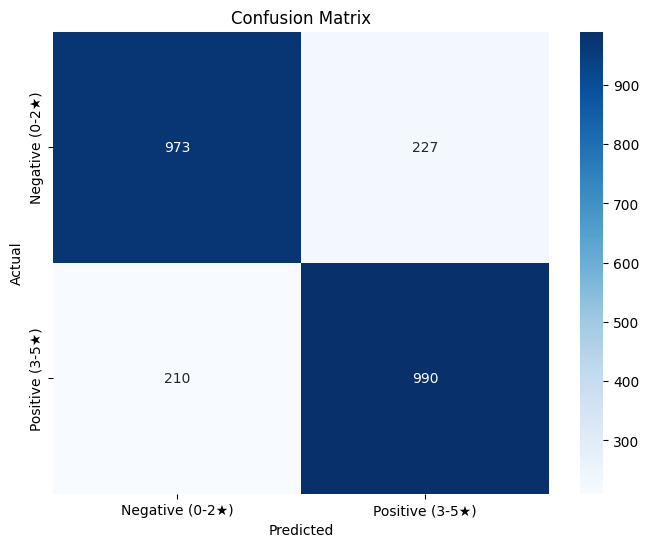

Confusion Matrix Values:
True Negatives: 973
False Positives: 227
False Negatives: 210
True Positives: 990


In [22]:
if df is not None and analyzer.model is not None:
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative (0-2★)', 'Positive (3-5★)'],
                yticklabels=['Negative (0-2★)', 'Positive (3-5★)'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    print("Confusion Matrix Values:")
    print(f"True Negatives: {cm[0,0]}")
    print(f"False Positives: {cm[0,1]}")
    print(f"False Negatives: {cm[1,0]}")
    print(f"True Positives: {cm[1,1]}")

In [27]:
test_reviews = [
    "IT IS PRETTY BAD",
    "This product is absolutely amazing and works perfectly!",
    "Terrible quality, complete waste of money, very disappointed",
    "Good value for the price, quite satisfied with purchase",
    "Could be better, not really impressed with the quality",
    "Outstanding quality, highly recommended to everyone!",
    "Poor customer service, product broke after one day",
    "Decent product, does what it's supposed to do",
    "Excellent build quality, exceeded my expectations!",
    "Average product, nothing special but works fine"
]

if analyzer.model is not None:
    print("="*70)
    print("STAR RATING PREDICTIONS")
    print("="*70)
    
    results = analyzer.predict_star_rating(test_reviews)
    
    for i, result in enumerate(results, 1):
        print(f"\\n{i:2d}. Review: '{result['text']}'")
        print(f"    Star Rating: {result['stars']}/5 {result['star_display']}")
        print(f"    Confidence: {result['confidence']:.3f}")
        print(f"    Positive Probability: {result['positive_probability']:.3f}")
        print("-" * 70)

STAR RATING PREDICTIONS
\n 1. Review: 'IT IS PRETTY BAD'
    Star Rating: 1/5 ★☆☆☆☆
    Confidence: 0.770
    Positive Probability: 0.230
----------------------------------------------------------------------
\n 2. Review: 'This product is absolutely amazing and works perfectly!'
    Star Rating: 4/5 ★★★★☆
    Confidence: 0.748
    Positive Probability: 0.748
----------------------------------------------------------------------
\n 3. Review: 'Terrible quality, complete waste of money, very disappointed'
    Star Rating: 0/5 ☆☆☆☆☆
    Confidence: 0.988
    Positive Probability: 0.012
----------------------------------------------------------------------
\n 4. Review: 'Good value for the price, quite satisfied with purchase'
    Star Rating: 4/5 ★★★★☆
    Confidence: 0.640
    Positive Probability: 0.640
----------------------------------------------------------------------
\n 5. Review: 'Could be better, not really impressed with the quality'
    Star Rating: 1/5 ★☆☆☆☆
    Confidence: 